In [1]:
!git clone https://github.com/cpwan/RLOR
%cd RLOR

Cloning into 'RLOR'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 52 (delta 12), reused 52 (delta 12), pack-reused 0
Unpacking objects: 100% (52/52), 5.19 MiB | 7.89 MiB/s, done.
/content/RLOR


In [2]:
import numpy as np
import torch
import gym
from models.attention_model_wrapper import Agent

# Define our agent

In [3]:
device = 'cuda'
ckpt_path = './runs/tsp-v0__ppo_or__1__1678160003/ckpt/12000.pt'
agent = Agent(device=device, name='tsp').to(device)
agent.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

# Define our environment

In [4]:
from wrappers.syncVectorEnvPomo import SyncVectorEnv
from wrappers.recordWrapper import RecordEpisodeStatistics

env_id = 'tsp-v0'
env_entry_point = 'envs.tsp_vector_env:TSPVectorEnv'
seed = 0

gym.envs.register(
    id=env_id,
    entry_point=env_entry_point,
)

def make_env(env_id, seed, cfg={}):
    def thunk():
        env = gym.make(env_id, **cfg)
        env = RecordEpisodeStatistics(env)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

envs = SyncVectorEnv([make_env(env_id, seed, dict(n_traj=1))])

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (50, 2)
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/vector

# Inference

In [5]:
num_steps = 51
trajectories = []
agent.eval()
obs = envs.reset()
for step in range(0, num_steps):
    # ALGO LOGIC: action logic
    with torch.no_grad():
        action, logits = agent(obs)
    obs, reward, done, info = envs.step(action.cpu().numpy())
    trajectories.append(action.cpu().numpy())

/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.9/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation sp

In [6]:
nodes_coordinates = obs['observations'][0]
final_return = info[0]['episode']['r']
resulting_traj = np.array(trajectories)[:,0,0]

## Results

In [7]:
print(f'A route of length {final_return}')
print('The route is:\n', resulting_traj)

A route of length [-5.908508]
The route is:
 [26 34 33 49 37 21 48 43 31 28 42 29 47 39 38 23 27 30  7 32 24 40 20 14
 25  1 18 22  0 11  2 16 45 15 46 12 17 41  8 13  3  6 44  9 10 19 36  5
 35  4 26]


## Display it in a 2d-grid
- Darker color means later steps in the route.

In [8]:
#@title Helper function for plotting
# colorline taken from https://nbviewer.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

def colorline(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=1, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.3, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = make_segments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc

def plot(coords):
    x,y = coords.T
    lc = colorline(x,y,cmap='Reds')
    plt.axis('square')
    return lc

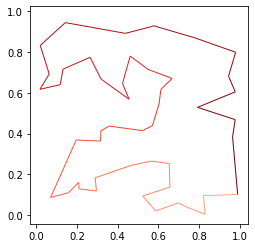

In [9]:
plot(nodes_coordinates[resulting_traj])